# Predict RUL with NASA Turbofan Data

Useful documents.
* [How to Implement Machine Learning For Predictive Maintenance](https://towardsdatascience.com/how-to-implement-machine-learning-for-predictive-maintenance-4633cdbe4860)
* [Predictive Maintenance ML (IIoT)](https://www.kaggle.com/billstuart/predictive-maintenance-ml-iiot)

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

dataset = pd.read_csv('../input/prehackathonsup/train_data/train_data.csv')

# "engine_no" and "time_in_cycled" are not required in prediction.
metacol = ['engine_no', 'time_in_cycles']

# ******************* Check Null data *********************** #
null_rate = (dataset.isnull().sum()/dataset.shape[0]) * 100

null_col = []
threshold_ratio = 99.5 #(%)

for i, x in enumerate(null_rate.index):
    if null_rate[i] > threshold_ratio:
        null_col.append(x)

# If Null Ratio is greater than threshold_ratio, drop the column from dataset
dataset = dataset.drop(columns=null_col)
print(f'Droppd columns are: {null_col}')
# ************************************************************ #

# Get Engine No. List
engine_list = dataset['engine_no'].drop_duplicates().values

Droppd columns are: ['sensor_22', 'sensor_23', 'sensor_24', 'sensor_25', 'sensor_26', 'sensor_27']


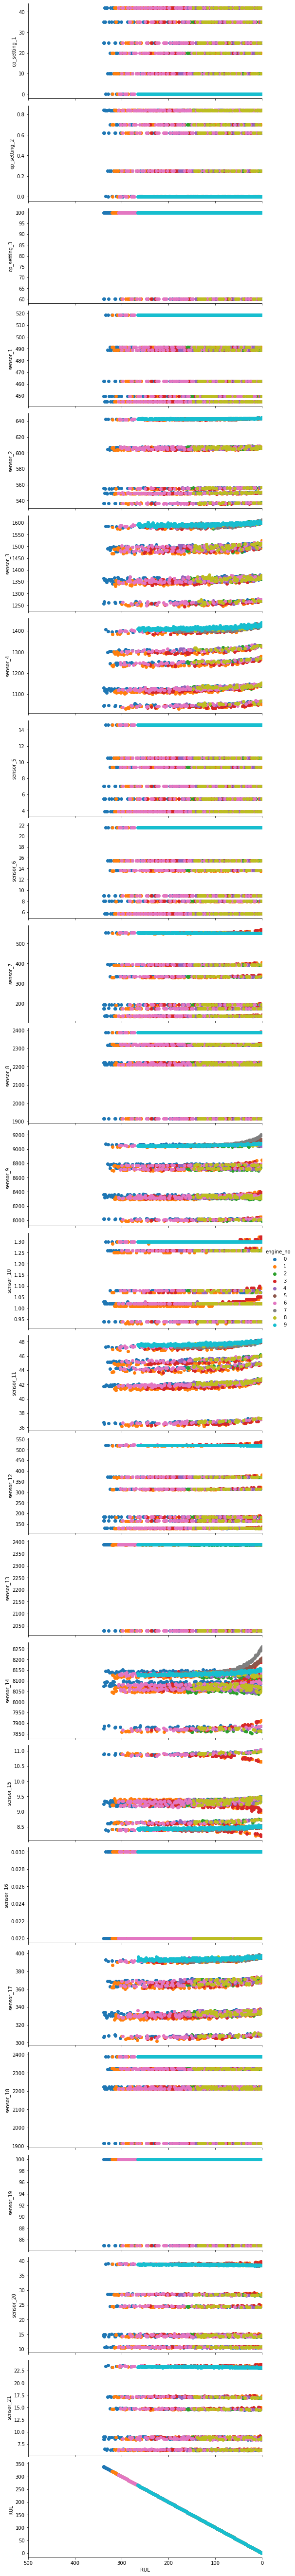

In [4]:
# use seaborn to visualize trend between features and target (RUL)
explore = sns.PairGrid(data=dataset.query('engine_no < 10') ,
                 x_vars=['RUL'],
                 y_vars=dataset.drop(columns=metacol).columns,
                 hue="engine_no", height=3, aspect=2.5)
explore = explore.map(plt.scatter)
explore = explore.set(xlim=(500,0))
explore = explore.add_legend()

# Data Visualization

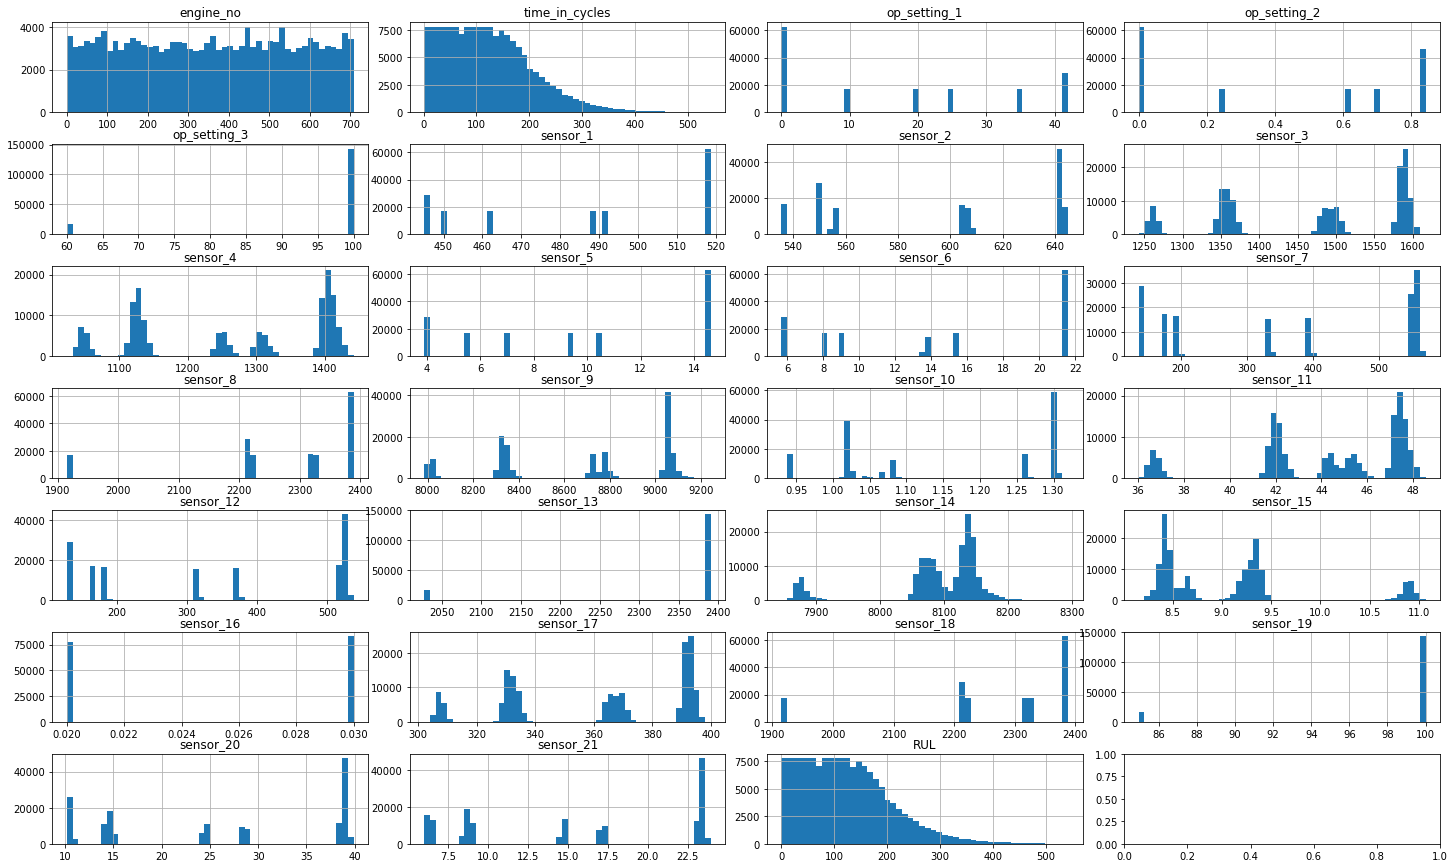

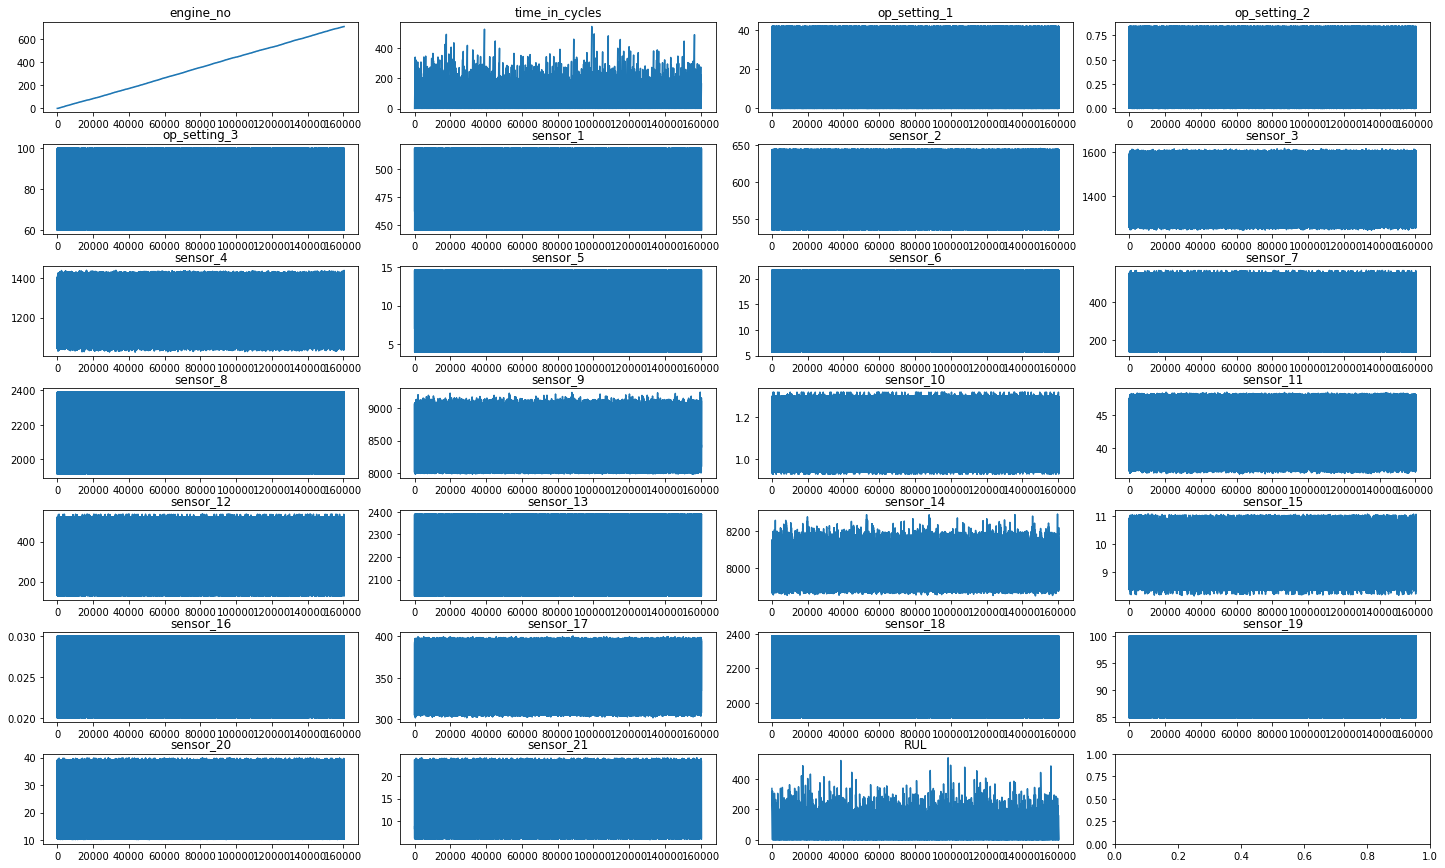

In [6]:
### Draw Histogram with all columns in dataset ###
#************************************************#
def visualize_hist(dataset):
    fig, ax = plt.subplots(ncols=4, nrows=7, figsize=(20,12))
    plt.tight_layout()
    for i, x in enumerate(dataset):
        row = int(i//4)
        col = int(i%4)
        dataset[x].hist(bins=50, ax=ax[row, col])
        ax[row, col].set_title(x)
#************************************************#


### Draw Plot with three "plot_list" columns ###
#**********************************************#
def visualize_plot(dataset):
    fig, ax = plt.subplots(ncols=4, nrows=7, figsize=(20,12))
    plt.tight_layout()
    for i, x in enumerate(dataset):
        row = int(i//4)
        col = int(i%4)
        dataset[x].plot(ax=ax[row, col])
        ax[row, col].set_title(x)
#**********************************************#


visualize_hist(dataset)

# Is there a large outlier??
visualize_plot(dataset)

In [ ]:
# Check correlation features vs RUL

corr = dataset.corr()
fig, ax = plt.subplots(figsize=(12,10))
heatmap = ax.pcolor(corr, cmap=plt.cm.Reds, vmax=1.0)
ax.set_xticks(np.arange(corr.shape[0]))
ax.set_yticks(np.arange(corr.shape[1]))
ax.set_xticklabels(corr.columns, rotation=90)
ax.set_yticklabels(corr.columns)
fig.colorbar(heatmap, ax=ax)

In [7]:
# Assign Features/Target variable

X = dataset.drop(columns=metacol).iloc[:,:-1]
y = dataset['RUL'].values

In [8]:
# See which features are the most important

from sklearn.ensemble import RandomForestRegressor

reg = RandomForestRegressor()
reg = RandomForestRegressor(n_estimators = 200, max_depth = 15)
reg.fit(X, y)
y_pred = reg.predict(X)
print("complete")

importances = reg.feature_importances_
columns=['col', 'val']
pd_importances = pd.DataFrame(columns=columns)
for i, x in enumerate(X.columns):
    pd_importances.loc[i] = [x, importances[i]]

# Get the most important columns in top10    
important_col = pd_importances.sort_values(by='val', ascending=False).reset_index()
print(important_col)

complete
    index           col       val
0      15     sensor_13  0.334006
1      13     sensor_11  0.203092
2      17     sensor_15  0.129151
3      11      sensor_9  0.074566
4       6      sensor_4  0.051199
5       8      sensor_6  0.050621
6      16     sensor_14  0.031162
7      14     sensor_12  0.025028
8       9      sensor_7  0.021541
9      10      sensor_8  0.016318
10      4      sensor_2  0.012575
11      5      sensor_3  0.012500
12     23     sensor_21  0.011171
13     22     sensor_20  0.008584
14      0  op_setting_1  0.008229
15      1  op_setting_2  0.005125
16     19     sensor_17  0.004259
17     12     sensor_10  0.000605
18     18     sensor_16  0.000256
19     20     sensor_18  0.000004
20      7      sensor_5  0.000004
21      3      sensor_1  0.000004
22     21     sensor_19  0.000000
23      2  op_setting_3  0.000000


In [9]:
# Get the most important columns in top18 
important_col = important_col.loc[:19, 'col']
print(important_col)

0        sensor_13
1        sensor_11
2        sensor_15
3         sensor_9
4         sensor_4
5         sensor_6
6        sensor_14
7        sensor_12
8         sensor_7
9         sensor_8
10        sensor_2
11        sensor_3
12       sensor_21
13       sensor_20
14    op_setting_1
15    op_setting_2
16       sensor_17
17       sensor_10
18       sensor_16
19       sensor_18
Name: col, dtype: object


# Hyperparameter Tuning

In [19]:
# Search the best hyper-parameter using Optuna integrated LightGBM

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import optuna.integration.lightgbm as lgb
import optuna
optuna.logging.set_verbosity(optuna.logging.CRITICAL)

params = {
    'objective': 'mean_squared_error',
    'metric': 'rmse',
    'verbosity': -1
}

# Data Preprocessing
scaler = StandardScaler()
X = scaler.fit_transform(dataset.loc[:,important_col].values)
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2)

trains = lgb.Dataset(X_tr, y_tr)
tests = lgb.Dataset(X_te, y_te)

model = lgb.train(params, trains, valid_sets=tests, verbose_eval=False, show_progress_bar=False)
print(f'best params = {model.params}')
print(f'best score = {model.best_score}')
best_params = model.params

KeyboardInterrupt: 

> best params = {'objective': 'mean_squared_error', 'metric': 'rmse', 'feature_pre_filter': False, 'lambda_l1': 9.209013255699873, 'lambda_l2': 5.861166768736052, 'num_leaves': 22, 'feature_fraction': 0.4, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_child_samples': 20, 'num_iterations': 1000, 'early_stopping_round': None}
best score = defaultdict(<class 'collections.OrderedDict'>, {'valid_0': OrderedDict([('rmse', 49.767768049741385)])})


In [37]:
# XGBoost Parameter tuning

import xgboost as xgb
from sklearn.metrics import r2_score, mean_squared_error
import optuna
optuna.logging.set_verbosity(optuna.logging.CRITICAL)
# XGBoost Parameters — xgboost 1.4.0-SNAPSHOT documentation https://xgboost.readthedocs.io/en/latest/parameter.html

def objective(trial):
    params = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'tree_method': 'gpu_hist',
        'eta': trial.suggest_loguniform('eta', 0.1, 1.0),
        'gamma': trial.suggest_loguniform('gamma', 0.001, 5.),
        'max_depth': trial.suggest_int('max_depth', 4, 10),
        'sub_sample': trial.suggest_loguniform('sub_sample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_loguniform('colsample_bytree', 0.5, 1.0),
        'lambda': trial.suggest_loguniform('lambda', 0.001, 0.01),
        'alpha': trial.suggest_loguniform('alpha', 0.001, 0.01),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.00001, 0.1),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
    }  
    
    xgb_model = xgb.XGBRegressor(**params)
    xgb_model.fit(X_tr, y_tr, eval_set = [(X_te, y_te)],  early_stopping_rounds=10, verbose=False)
    y_pred = xgb_model.predict(X)
    
    return np.sqrt(mean_squared_error(y, y_pred))

study = optuna.create_study()
study.optimize(objective, n_trials=50, n_jobs=-1)
xgb_best = study.best_params
print(xgb_best)

{'eta': 0.16581083837047908, 'gamma': 0.5061632456074894, 'max_depth': 5, 'sub_sample': 0.5002260736747305, 'colsample_bytree': 0.6170119769346691, 'lambda': 0.007605338785348374, 'alpha': 0.0022354433956978175, 'learning_rate': 0.01855331848789157, 'n_estimators': 259}


> {'eta': 0.12294493010797729, 'gamma': 0.06882131325279922, 'max_depth': 10, 'sub_sample': 0.8058550867403695, 'colsample_bytree': 0.5052660986445803, 'lambda': 0.005195480949665515, 'alpha': 0.0013480986056236027, 'learning_rate': 0.015100504529824567, 'n_estimators': 557}

# Train and Fit model

In [39]:
import lightgbm as lgb

regressor = lgb.LGBMRegressor(**best_params)
regressor.fit(X_tr, y_tr, eval_set=(X_te, y_te), verbose=0)
lgb_y_pred = regressor.predict(X)

xgb_model = xgb.XGBRegressor(**xgb_best)
xgb_model.fit(X_tr, y_tr, eval_set = [(X_te, y_te)],  early_stopping_rounds=10, verbose=0)
xgb_y_pred = xgb_model.predict(X)

def draw_rul_graph(y_act, y_pred):
    fig, ax = plt.subplots(figsize=(8,6))
    ax.scatter(y_act, y_pred)
    ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
    ax.set_xlabel('Actual RUL')
    ax.set_ylabel('Predicted RUL')
    ax.set_title('RUL Actual vs. Predicted')
    plt.show()

draw_rul_graph(y, lgb_y_pred)
draw_rul_graph(y, xgb_y_pred)

NameError: name 'lgb_y_pred' is not defined

In [ ]:
# K-Folds cross-validation stacking
from sklearn.model_selection import KFold
cv = KFold(n_splits=5, shuffle=True, random_state=42)

def cv_stacking(X, y, model):
    counter = 0

    for tridx, teidx in cv.split(X):
        xtr_cv, xte_cv = X[tridx], X[teidx]
        ytr_cv, yte_cv = y[tridx], y[teidx]
        
        try:
            model.fit(xtr_cv, ytr_cv, eval_set=(xte_cv, yte_cv), verbose=0)
        except:
            model.fit(xtr_cv, ytr_cv, eval_set=[(xte_cv, yte_cv)], verbose=0)
            # I know this try-except architecture is not good. But don't care :P
        y_pred = model.predict(X)

        if counter == 0:
            summary = np.zeros(y_pred.shape[0])

        summary += y_pred
        counter += 1

    return summary

lgb_sum = cv_stacking(X, y, lgb.LGBMRegressor(**best_params))
xgb_sum = cv_stacking(X, y, xgb.XGBRegressor(**xgb_best))

summary = (lgb_sum + xgb_sum)/10

draw_rul_graph(y, summary)